In [4]:
import argparse, os, sys, subprocess
import torch
import torch.nn.functional as F

import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from models.flownet2.models import FlowNet2
from models.flownet2.utils import tools
from models.flownet2 import models, losses
from models.flownet2.utils.flow_utils import *

from models.pwc_net.models.PWCNet import PWCDCNet

from utils.plotting import overlaySegment, countParameters
from utils.layers import warp
from utils.encoding import dice_coeff, labelMatrixOneHot

### Loading PWC Net

In [3]:
pwc = PWCDCNet()
state_dict = torch.load("models/PWC_Net/PyTorch/pwc_net_chairs.pth.tar")
pwc.load_state_dict(state_dict)
print("A new player has entered the game")

/home/till/uni/MasterThesis/models/PWC_Net/PyTorch/models/PWCNet.py:142: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):


A new player has entered the game


### Loading FlowNet2

In [4]:
parser = argparse.ArgumentParser()

parser.add_argument('--start_epoch', type=int, default=1)
parser.add_argument('--total_epochs', type=int, default=10000)
parser.add_argument('--batch_size', '-b', type=int, default=8, help="Batch size")
parser.add_argument('--train_n_batches', type=int, default = -1, help='Number of min-batches per epoch. If < 0, it will be determined by training_dataloader')
parser.add_argument('--crop_size', type=int, nargs='+', default = [256, 256], help="Spatial dimension to crop training samples for training")
parser.add_argument('--gradient_clip', type=float, default=None)
parser.add_argument('--schedule_lr_frequency', type=int, default=0, help='in number of iterations (0 for no schedule)')
parser.add_argument('--schedule_lr_fraction', type=float, default=10)
parser.add_argument("--rgb_max", type=float, default = 255.)

parser.add_argument('--number_workers', '-nw', '--num_workers', type=int, default=8)
parser.add_argument('--number_gpus', '-ng', type=int, default=-1, help='number of GPUs to use')
parser.add_argument('--no_cuda', action='store_true')

parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--name', default='run', type=str, help='a name to append to the save directory')
parser.add_argument('--save', '-s', default='./work', type=str, help='directory for saving')

parser.add_argument('--validation_frequency', type=int, default=5, help='validate every n epochs')
parser.add_argument('--validation_n_batches', type=int, default=-1)
parser.add_argument('--render_validation', action='store_true', help='run inference (save flows to file) and every validation_frequency epoch')

parser.add_argument('--inference', action='store_true')
parser.add_argument('--inference_visualize', action='store_true',
                    help="visualize the optical flow during inference")
parser.add_argument('--inference_size', type=int, nargs='+', default = [-1,-1], help='spatial size divisible by 64. default (-1,-1) - largest possible valid size would be used')
parser.add_argument('--inference_batch_size', type=int, default=1)
parser.add_argument('--inference_n_batches', type=int, default=-1)
parser.add_argument('--save_flow', action='store_true', help='save predicted flows to file')

parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--log_frequency', '--summ_iter', type=int, default=1, help="Log every n batches")

parser.add_argument('--skip_training', action='store_true')
parser.add_argument('--skip_validation', action='store_true')

parser.add_argument('--fp16', action='store_true', help='Run model in pseudo-fp16 mode (fp16 storage fp32 math).')
parser.add_argument('--fp16_scale', type=float, default=1024., help='Loss scaling, positive power of 2 values can improve fp16 convergence.')

tools.add_arguments_for_module(parser, models, argument_for_class='model', default='FlowNet2')

tools.add_arguments_for_module(parser, losses, argument_for_class='loss', default='L1Loss')

tools.add_arguments_for_module(parser, torch.optim, argument_for_class='optimizer', default='Adam', skip_params=['params'])

args, unknown = parser.parse_known_args()
flownet = FlowNet2(args)
flownet.load_state_dict(torch.load("models/flownet2/weights/FlowNet2_checkpoint.pth.tar")['state_dict'])
print("A new player has entered the game")

A new player has entered the game


In [5]:
print("PWC has ", countParameters(pwc), " Parameters")
print("FlowNet has ", countParameters(flownet), " Parameters")

PWC has  9374340  Parameters
FlowNet has  162518834  Parameters


### Preprocessing functions

In [6]:
def preprocessing_pwc(img_1, img_2):
    """
    Preprocessing function for PWC net.
    img1: numpy.ndarray in shape of (H,W,C)
    img2: numpy.ndarray in shape of (H,W,C)
    
    return: torch.tensor in the shape of (1,2*C,H,W)
    """
    img1 = img_1.numpy().copy()
    img2 = img_2.numpy().copy()

    H,W,C = img_1.shape   
    
    divisor = 64
    H_ = int(ceil(H/divisor) * divisor)
    W_ = int(ceil(W/divisor) * divisor)
        
    img1 = cv2.resize(np.concatenate([img1,img1,img1], 2), (W_,H_))
    img2 = cv2.resize(np.concatenate([img2,img2,img2], 2), (W_,H_))
        
    images = [img1,img2]
    
    
    for _i, _inputs in enumerate(images):
        images[_i] = images[_i][:, :, ::-1]

        images[_i] = np.transpose(images[_i], (2, 0, 1))

        # Running into a "negative number" error in th line below, need to change that
        # The error suggested to use the copy() function as a workaround. 
        images[_i] = torch.from_numpy(images[_i].copy())
        # Worked ¯\_(ツ)_/¯

        images[_i] = images[_i].expand(1, images[_i].size()[0], images[_i].size()[1], images[_i].size()[2])	
        images[_i] = images[_i].float()
    
    return torch.cat(images,1)

def preprocessing_flownet(img_1, img_2):
    """
    Preprocessing function for PWC net.
    img1: numpy.ndarray in shape of (H,W,C)
    img2: numpy.ndarray in shape of (H,W,C)
    
    return: torch.tensor in the shape of (1,B,C,H,W)
    
    """
    img1 = img_1.numpy().copy()
    img2 = img_2.numpy().copy()
    
    if img1.max() <= 1.0:
        img1 = img1 * 255
    if img2.max() <= 1.0:
        img2 = img2 * 255
        
    if img1.shape[2] == 1:
        img1 = np.concatenate([img1,img1,img1], 2)
    
    if img2.shape[2] == 1:
        img2 = np.concatenate([img2,img2,img2], 2)
    
    images = [img1, img2]
    images = np.array(images).transpose(3, 0, 1, 2)
    return torch.from_numpy(images.astype(np.float32)).unsqueeze(0)


## Loading Torso Images

In [8]:
img = torch.load('Tests/img.pth') 
seg = torch.load('Tests/seg.pth')

In [18]:
fix = 9; mov = 10;
fixed = img[fix:fix+1,:,:].float() /255
moving = img[mov:mov+1,:,:].float() /255

fixed_seg = seg[fix:fix+1, :,:].long().contiguous()
moving_seg = seg[mov:mov+1,:,:].long().contiguous()

C,H,W = fixed.shape

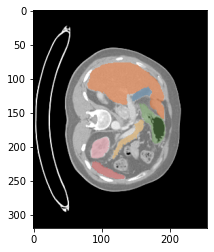

In [19]:
over = overlaySegment(moving.squeeze(),moving_seg.squeeze(),True)

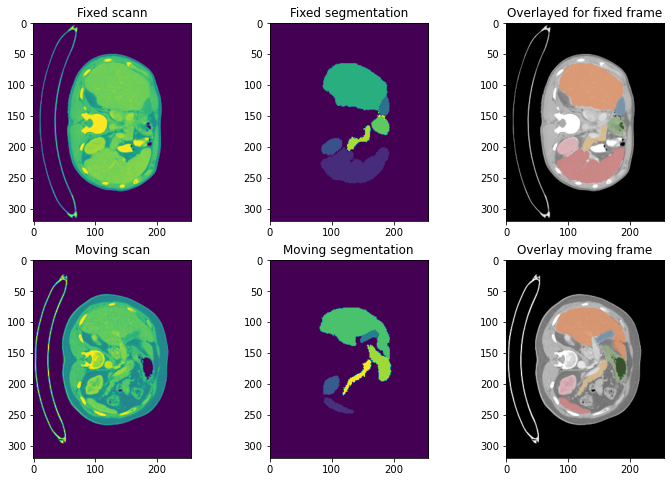

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title("Fixed scann")
plt.imshow(fixed.squeeze())
plt.subplot(232)
plt.title("Fixed segmentation")
plt.imshow(fixed_seg.squeeze())
plt.subplot(233)
plt.title("Overlayed for fixed frame")
plt.imshow(overlaySegment(fixed.squeeze(),fixed_seg.squeeze(), False).numpy())
plt.subplot(234)
plt.title("Moving scan")
plt.imshow(moving.squeeze())
plt.subplot(235)
plt.title("Moving segmentation")
plt.imshow(moving_seg.squeeze())
plt.subplot(236)
plt.title("Overlay moving frame")
plt.imshow(overlaySegment(moving.squeeze(),moving_seg.squeeze(),False).numpy())
plt.show()

In [21]:
flownet_input = preprocessing_flownet(fixed.reshape(H,W,C),moving.reshape(H,W,C))
pwc_input = preprocessing_pwc(fixed.reshape(H,W,C),moving.reshape(H,W,C))
print("FlowNet Input: ", flownet_input.shape)
print("PWCNet Input: ", pwc_input.shape)

FlowNet Input:  torch.Size([1, 3, 2, 320, 256])
PWCNet Input:  torch.Size([1, 6, 320, 256])


## FlowNet2 Inference

In [22]:
flownet.cuda()
flow_1 = flownet(flownet_input.cuda()).cpu()
flownet.cpu()
data = flow_1.squeeze().cpu().detach().numpy().transpose(1,2,0)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


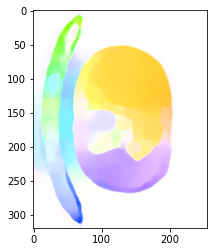

In [23]:
plt.imshow(flow2img(data))

In [24]:
flow_1.shape

torch.Size([1, 2, 320, 256])

In [25]:
warped_seg_2 = warp(moving_seg.unsqueeze(0).float().cuda(), flow_1.cuda()).cpu().squeeze().to(torch.int64)

In [35]:
d0 = dice_coeff(moving_seg,fixed_seg,8)
print(d0, d0.mean())

tensor([0.2324, 0.8239, 0.0000, 0.0000, 0.7553, 0.6179, 0.6296]) tensor(0.4370)


In [27]:
d1 = dice_coeff(warped_seg_2.unsqueeze(0), fixed_seg, 8)
print(d1, d1.mean())

tensor([0.2096, 0.6530, 0.0156, 0.0000, 0.7644, 0.5487, 0.3973]) tensor(0.3698)


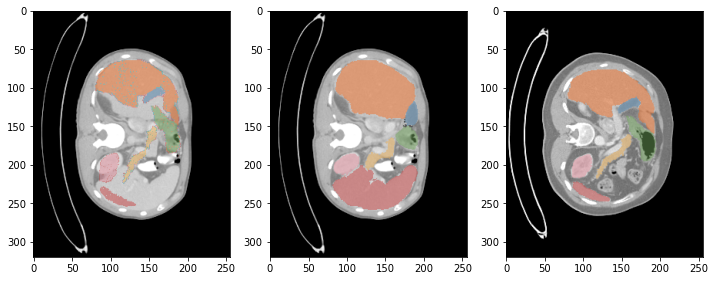

In [39]:
fig = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(overlaySegment(fixed.squeeze(),warped_seg_2.squeeze() ,False).numpy())
plt.subplot(132)
plt.imshow(overlaySegment(fixed.squeeze(),fixed_seg.squeeze() ,False).numpy())
plt.subplot(133)
plt.imshow(overlaySegment(moving.squeeze(),moving_seg.squeeze(),False).numpy())

### Verdict FlowNet

Seems to work out of the box for medical data. Some finetuning needs to happen to make the flownet a suitable teacher, tho. For the fine tuning the focus should be on small number of epochs and a small amount of data, so that the majority of data can be used for the student teacher

## PWC-Net inferences

In [29]:
pwc.cuda()
pwc.eval()

flow_pwc = pwc(pwc_input.cuda())

flow_pwc = flow_pwc[0]*20
flow_pwc = flow_pwc.cpu().data.numpy()

flow_pwc = np.swapaxes(np.swapaxes(flow_pwc, 0, 1), 1, 2) 

u_ = cv2.resize(flow_pwc[:,:,0],(W,H))
v_ = cv2.resize(flow_pwc[:,:,1],(W,H))
flow_pwc = np.dstack((u_,v_))
flow_pwc.shape

torch.Size([1, 81, 5, 4])


(320, 256, 2)

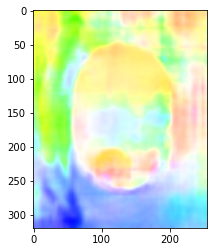

In [30]:
plt.imshow(flow2img(flow_pwc))
flow_pwc = torch.from_numpy(flow_pwc)

In [31]:
warped_flow = warp(moving_seg.unsqueeze(0).float().cuda(), flow_pwc.reshape(1,2,H,W).cuda()).cpu().squeeze().to(torch.int64)

In [37]:
d0 = dice_coeff(moving_seg,fixed_seg,8)
print(d0, d0.mean())

d1 = dice_coeff(warped_flow.unsqueeze(0), fixed_seg, 8)
print(d1, d1.mean())

tensor([0.2324, 0.8239, 0.0000, 0.0000, 0.7553, 0.6179, 0.6296]) tensor(0.4370)
tensor([0.1548, 0.3797, 0.0156, 0.0000, 0.6984, 0.5178, 0.3917]) tensor(0.3083)


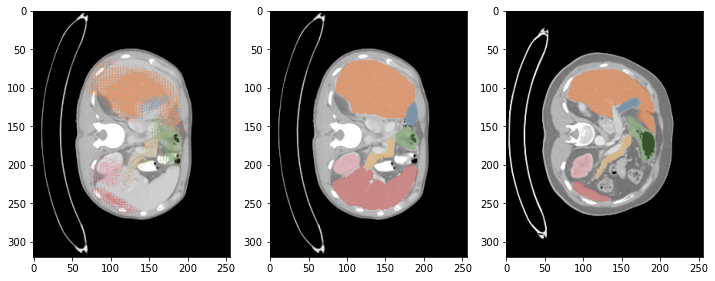

In [38]:
fig = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(overlaySegment(fixed.squeeze(),warped_flow.squeeze() ,False).numpy())
plt.subplot(132)
plt.imshow(overlaySegment(fixed.squeeze(),fixed_seg.squeeze() ,False).numpy())
plt.subplot(133)
plt.imshow(overlaySegment(moving.squeeze(),moving_seg.squeeze(),False).numpy())

### Verdict PWCNet

needs some more fine tuning than flowNet2. Also the flow estimation is not as smooth as from FlowNet2. Performance could be better, but can be used after fine tuning, I guess